In [1]:
import sys
import numpy as np
import argparse
from copy import deepcopy
import torch
from env import EIEnv
from evaluator import Evaluator
from ddpg import DDPG
from util import *
parser = argparse.ArgumentParser(description='PyTorch on TORCS with Multi-modal')
parser.add_argument('--mode', default='train', type=str, help='support option: train/test')
parser.add_argument('--env', default='microgrid', type=str, help='')
parser.add_argument('--pre_training', default= True, type=bool, help='')
parser.add_argument('--rate', default=1e-3, type=float, help='learning rate')
parser.add_argument('--prate', default=2e-4, type=float, help='policy net learning rate (only for DDPG)')
parser.add_argument('--warmup', default=4*24*5, type=int, help='time without training but only filling the replay memory')
parser.add_argument('--discount', default=0.95, type=float, help='')
parser.add_argument('--bsize', default=64, type=int, help='minibatch size')
parser.add_argument('--rmsize', default=600000, type=int, help='memory size')
parser.add_argument('--window_length', default=1, type=int, help='')
parser.add_argument('--tau', default=0.001, type=float, help='moving average for target network')
parser.add_argument('--ou_theta', default=0.15, type=float, help='noise theta')
parser.add_argument('--ou_sigma', default=0.3, type=float, help='noise sigma') 
parser.add_argument('--ou_mu', default=0.0, type=float, help='noise mu') 
parser.add_argument('--validate_episodes', default=10, type=int, help='how many episode to perform during validate experiment')
parser.add_argument('--episodes_update_interval', default=10, type=int, help='how many episodes to update network')
parser.add_argument('--episodes_validate_interval', default=100, type=int, help='how many train episodes to perform a validate experiment')
parser.add_argument('--output', default='output', type=str, help='')
parser.add_argument('--debug', dest='debug', action='store_true')
parser.add_argument('--init_w', default=0.003, type=float, help='') 
parser.add_argument('--train_iter', default=3e8, type=int, help='train iters each timestep')
parser.add_argument('--epsilon', default=50000, type=int, help='linear decay of exploration policy')
parser.add_argument('--seed', default=-1, type=int, help='')
parser.add_argument('--cuda', default=True, type=bool, help='')
parser.add_argument('--resume', default='default', type=str, help='Resuming model path for testing')
args, unknown = parser.parse_known_args()

In [20]:
import torch
from env import EIEnv
from ddpg import DDPG
env = EIEnv()
nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.shape[0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
agent = DDPG(nb_states, nb_actions, device, args)
agent.load_best_weights('./output')
agent.is_training = False
agent.eval()
policy = lambda x: agent.select_action(x, decay_epsilon=False)
%config InlineBackend.figure_format='svg'
%matplotlib inline

/home/zhaoming/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [21]:
episode_steps = 0
costs = np.zeros([1439,17])
obs = np.zeros([1439,20])
T_in = np.zeros([1439,10])
E_EV = np.zeros([1439,5])
actions = np.zeros([1439,16])

#print(observation)
np.random.seed(1)
observation = env.reset()
assert observation is not None
# start episode
done = False
while not done:
    # basic operation, action ,reward, blablabla ...
    action = policy(observation)
    actions[episode_steps] = action
    observation, reward, done, info = env.step(action)
    obs[episode_steps]= observation
    T_in[episode_steps]=env.T_in
    costs[episode_steps]=reward
    E_EV[episode_steps]=env.E_EV
    episode_steps += 1

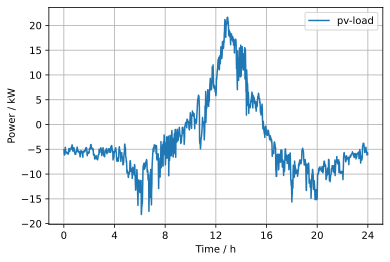

In [22]:
import matplotlib.pyplot as plt
plt.plot(obs[:,0], obs[:,1], label='pv-load')
#plt.xlim(0,24)
#plt.ylim(0,10)
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/DG.svg',format='svg')
plt.show()

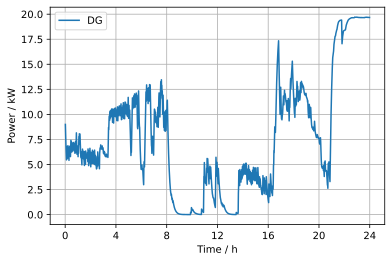

In [23]:
import matplotlib.pyplot as plt
plt.plot(obs[:,0], obs[:,2], label='DG')
#plt.plot(obs[:,0], actions[:,0],label='uDG')
#plt.xlim(0,24)
#plt.ylim(0,10)
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/DG.svg',format='svg')
plt.show()

In [24]:
actions[:,0]

array([5.33168612e-04, 5.22752234e-04, 4.53169079e-04, ...,
       9.82905030e-01, 9.82995808e-01, 9.83076215e-01])

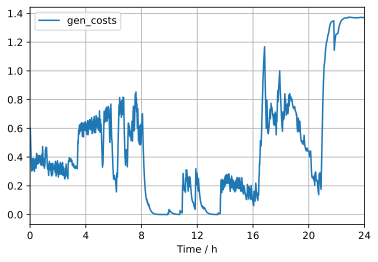

In [25]:
import matplotlib.pyplot as plt
plt.plot(obs[:,0], costs[:,0], label='gen_costs')
plt.xlim(0,24)
#plt.ylim(0,10)
plt.xlabel('Time / h')
#plt.ylabel('Power / kW')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/DG.svg',format='svg')
plt.show()

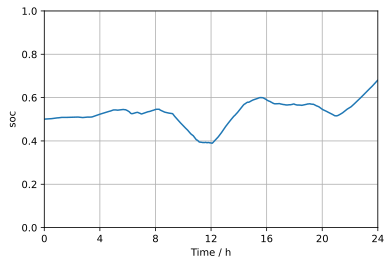

In [26]:
plt.plot(obs[:,0], obs[:,3])
plt.ylim(0,1)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('soc')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

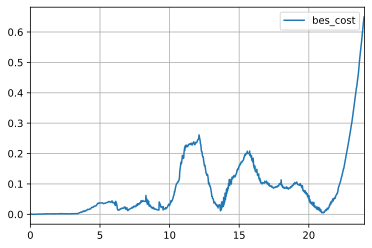

In [27]:
plt.plot(obs[:-1,0], costs[:-1,1], label='bes_cost')
#plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

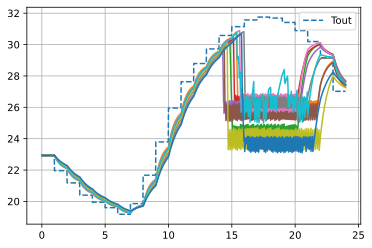

In [28]:
import matplotlib.pyplot as plt
plt.plot(obs[:,0],obs[:,4], '--', label='Tout')
for i in range(10):
    plt.plot(obs[:,0],T_in[:,i])
#plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

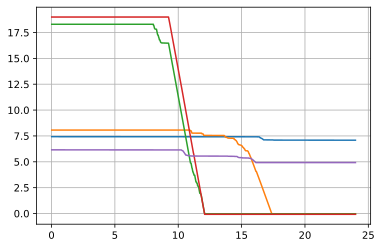

In [29]:
#plt.plot(obs[:,0],obs[:,4], '--', label='Tout')
for i in range(5):
    plt.plot(obs[:,0],E_EV[:,i])
#plt.xlim(0,24)
plt.grid()
#plt.legend()
plt.show()

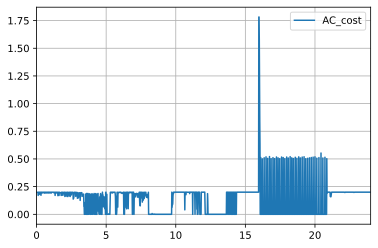

In [30]:
plt.plot(obs[:,0], costs[:,-4], label='AC_cost')
#plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

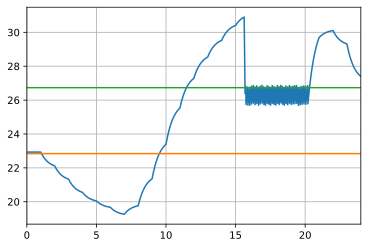

In [31]:
n=5
plt.plot(obs[:,0],T_in[:,n])
plt.plot(obs[:,0], env.Tlower[n]*np.ones(1439), label='Tlower')
plt.plot(obs[:,0], env.Tupper[n]*np.ones(1439), label='Tupper')
plt.xlim(0,24)
plt.grid()
plt.show()

In [ ]:
n=10
plt.plot(steps[:,0],steps[:,5], '--', label='out temperature')
plt.plot(steps[:,0],steps[:,-(30-n)], 'C0', label = 'indoor temperature')
plt.plot(steps[:,0], env.Tupper[n]*np.ones(1438), 'C1--' ,label='upper temperature without loss')
plt.plot(steps[:,0], env.Tlower[n]*np.ones(1438),'C2--', label='lower temperature without loss')
plt.plot(env.start_AC_time[n], steps[int(60*env.start_AC_time[n])-1,-(30-n)], 'ro')
plt.text(env.start_AC_time[n], steps[int(60*env.start_AC_time[n])-1,-(30-n)]+0.5, 'start time')
plt.plot(env.end_AC_time[n], steps[int(60*env.end_AC_time[n])-1,-(30-n)],'ro')
plt.text(env.end_AC_time[n]+0.5, steps[int(60*env.end_AC_time[n])-1,-(30-n)]-0.5, 'end time')
plt.xlim(0,24)
plt.ylim(18,32)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

In [ ]:
AC_prob

In [ ]:
n=10
plt.plot(steps_compare[:,0],steps_compare[:,5], '--', label='out temperature')
plt.plot(steps_compare[:,0],steps_compare[:,-(30-n)], 'C0', label = 'indoor temperature')
plt.plot(steps_compare[:,0], env.Tupper[n]*np.ones(1438), 'C1--' ,label='upper temperature without loss')
plt.plot(steps_compare[:,0], env.Tlower[n]*np.ones(1438),'C2--', label='lower temperature without loss')
plt.plot(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)], 'ro')
plt.text(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)]+0.5, 'start time')
plt.plot(env.end_AC_time[n], steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)],'ro')
plt.text(env.end_AC_time[n]+0.5, steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)]-0.5, 'end time')
plt.xlim(0,24)
plt.ylim(18,32)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

In [ ]:
plt.plot(steps[:,0],steps[:,6], 'C0', label='EV1')
plt.plot(steps_compare[:,0],steps_compare[:,6], 'C0--', label='EV1')
plt.plot(env.start_charge_time[0],steps_compare[0,6],'C0o')
plt.plot(env.end_charge_time[0],steps_compare[-1,6],'C0o')
plt.plot(steps[:,0],steps[:,6+10], 'C1', label='EV2')
plt.plot(steps_compare[:,0],steps_compare[:,6+10], 'C1--', label='EV2')
plt.plot(env.start_charge_time[10],steps_compare[0,16],'C1o')
plt.plot(env.end_charge_time[10],steps_compare[-1,16],'C1o')
#plt.plot(steps[:,0],steps[:,6+15],'C2', label='EV3')
#plt.plot(steps_compare[:,0],steps_compare[:,6+15],'C2--', label='EV3')
#plt.plot(env.start_charge_time[15],steps_compare[0,21],'C2o')
#plt.plot(env.end_charge_time[15],steps_compare[-1,21],'C2o')
#plt.ylim(-0.1,15)
plt.xlim(0,24)
plt.ylim(-1,20)
plt.ylabel('Remaining charging energy / kWh')
plt.xlabel('Time / h')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/EV.svg',format='svg')
plt.show()

In [ ]:
n=10
plt.plot(steps_compare[:,0],steps_compare[:,5], 'C0--', label='out temperature')
plt.plot(steps[:,0],steps[:,-(30-n)], 'C1', label = 'indoor temperature with DRL')
plt.plot(steps_compare[:,0],steps_compare[:,-(30-n)], 'C1--', label = 'indoor temperature without DRL')
plt.plot(steps_compare[:,0], env.Tupper[n]*np.ones(1438), 'C2')
plt.text(1, env.Tupper[n]+0.5, '$T_{max}$')
plt.plot(steps_compare[:,0], env.Tlower[n]*np.ones(1438),'C2--')
plt.text(1, env.Tlower[n]-0.7, '$T_{min}$')
#plt.plot(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)], 'ro')
#plt.text(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)]+0.5, 'start time')
#plt.plot(env.end_AC_time[n], steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)],'ro')
#plt.text(env.end_AC_time[n]+0.5, steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)]-0.5, 'end time')
plt.fill_between(np.linspace(env.start_AC_time[n],env.end_AC_time[n],100),18*np.ones(100), 36*np.ones(100),color='lightskyblue')
plt.xlim(0,24)
plt.ylim(18,36)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

In [ ]:
plt.plot(steps[:,0], steps[:,3], 'C0', label='DRL')
plt.plot(steps_compare[:,0], steps_compare[:,3], 'C0--', label='without DRL')
plt.ylim(0,1)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('soc')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

In [ ]:
import numpy as np
xs = np.zeros(1440)
mu = 0
theta = 0.15
sigma = 0.3
x_prev=0
dt = 1./60
for i in range(1440):
    x = x_prev + theta * (mu - x_prev) * dt + sigma * np.sqrt(dt) * np.random.normal()
    x_prev = x
    xs[i]=x

In [ ]:
plt.plot(xs)
plt.show()

In [ ]:
np.load('./Data/para_a.npy')

In [ ]:
np.load('./Data/para_b.npy')

In [4]:
import numpy as np
N=10
mu = 4*np.load('./Data/mu.npy')[:N]
mu

array([0.7911588 , 0.69843892, 0.63441185, 0.57784433, 0.66230148,
       0.75127638, 0.42358155, 0.42931765, 0.52508841, 0.6053307 ])

In [5]:
AC_a = np.load('./Data/para_a.npy')[:N]
AC_b = np.load('./Data/para_b.npy')[:N]
Tupper = np.load('./Data/Tupper.npy')[:N]
Tlower = np.load('./Data/Tlower.npy')[:N]

In [9]:
AC_b

array([39.70091904, 33.73590342, 27.42147775, 27.16182235, 33.87194844,
       35.62716071, 23.21764878, 28.79188916, 34.18361587, 21.26672388])

In [ ]:
import numpy as np
A = np.zeros([[1,2,3],[4,5,6],[7,8,9]])
A[:,1,2]

In [ ]:
A = torch.tensor([0,1,2])
torch.stack((A,A),dim=1)